In [1]:
from os.path import abspath, expanduser

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter


import numpy as np
import pandas as pd
import rasters as rt

from ECOv002_CMR import ECOSTRESS_CMR_search, download_file, GranuleID, download_ECOSTRESS_granule
from ECOv002_granules import ET_COLORMAP, NDVI_COLORMAP

from PTJPL import PTJPL, load_fAPARmax, load_Topt

%matplotlib inline

In [2]:
import logging

logging.getLogger().handlers = []

In [3]:
aquisition_date = "2024-10-22"
orbit = 35698
scene = 14
tile = "11SPS"
ECOSTRESS_download_directory = abspath(expanduser("~/data/ECOSTRESS"))
static_directory = abspath(expanduser("~/data/JET_static"))
working_directory = abspath(expanduser("~/data/ECOv002_L3T_L4T_JET"))

In [4]:
error_cmap = LinearSegmentedColormap.from_list("error", ["blue", "white", "red"])

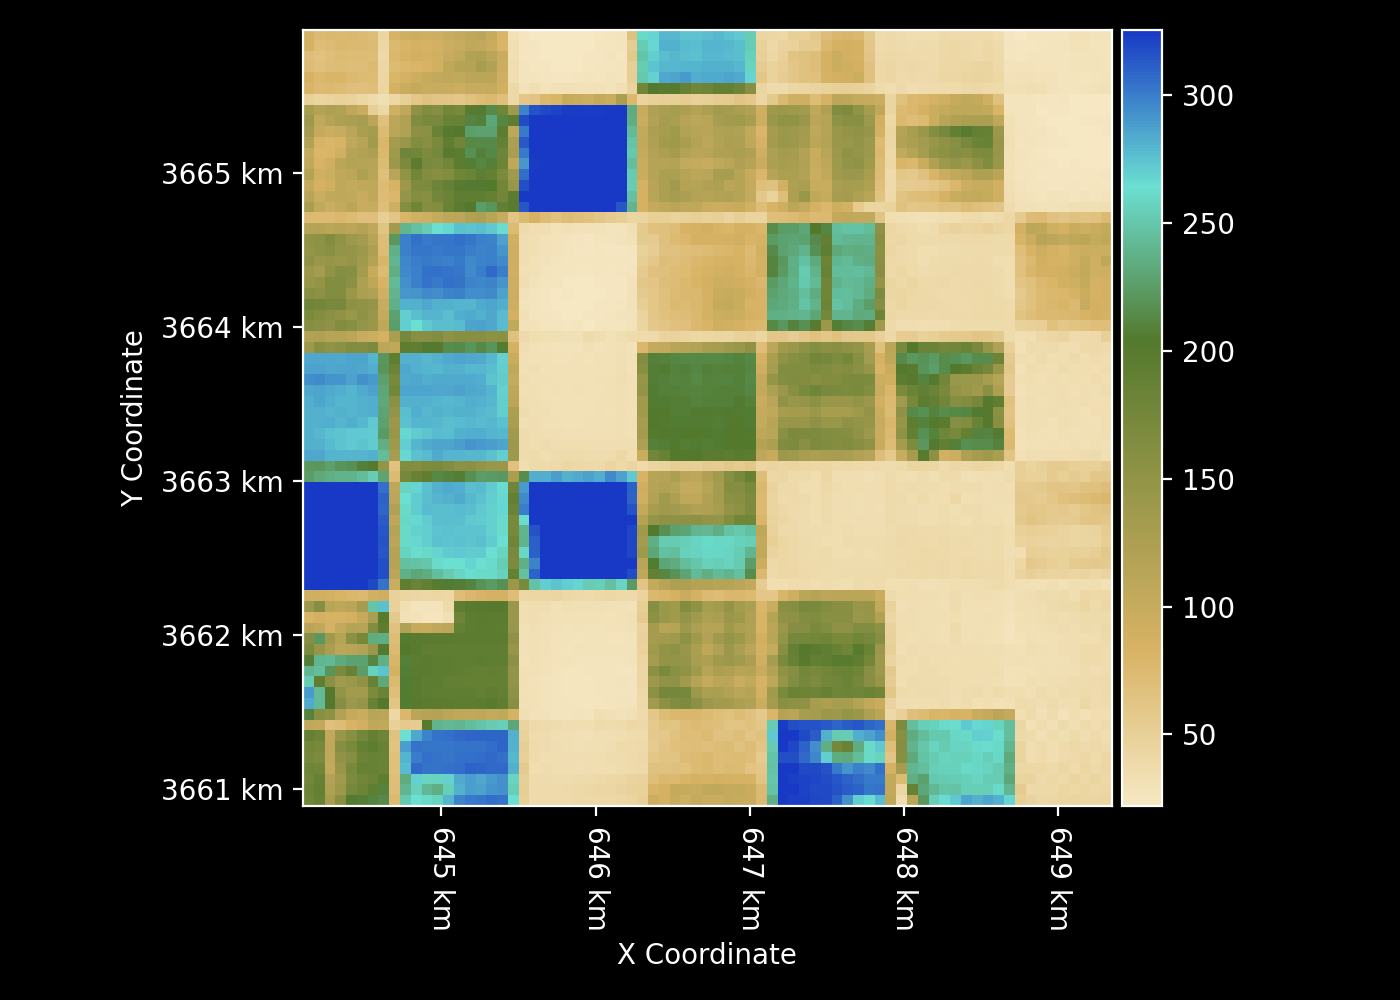

In [5]:
subset = rt.Raster.open("farms_subset.tif")
subset.cmap = ET_COLORMAP
subset

In [6]:
geometry = subset.geometry
geometry

{
  "dimensions": {
    "rows": 72,
    "cols": 75
  },
  "bbox": {
    "xmin": 644100.0,
    "ymin": 3660890.0,
    "xmax": 649350.0,
    "ymax": 3665930.0
  },
  "crs": "EPSG:32611",
  "resolution": {
    "cell_width": 70.0,
    "cell_height": -70.0
  }
}

In [7]:
L2T_LSTE_granule = download_ECOSTRESS_granule(
    product="L2T_LSTE", 
    orbit=orbit,
    scene=scene,
    tile=tile, 
    aquisition_date=aquisition_date,
    parent_directory=ECOSTRESS_download_directory
)

L2T_LSTE_granule

L2TLSTE("/Users/gregoryhalverson/data/ECOSTRESS/ECOv002_L2T_LSTE_35698_014_11SPS_20241022T183627_0713_01")

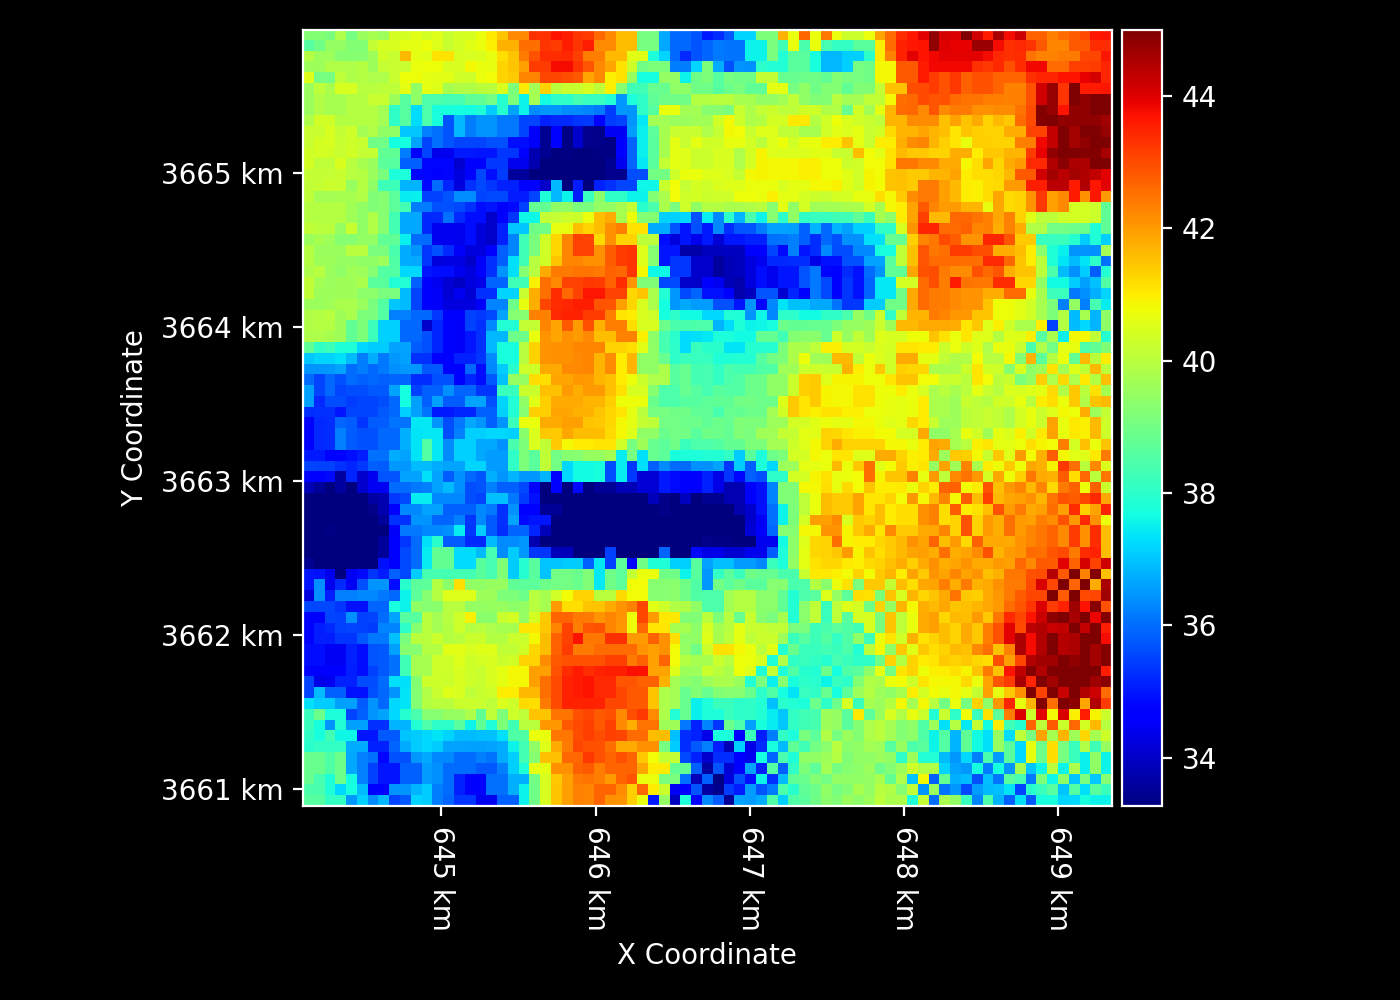

In [8]:
ST_C = L2T_LSTE_granule.ST_C.to_geometry(geometry)
ST_C

In [9]:
L2T_STARS_granule = download_ECOSTRESS_granule(
    product="L2T_STARS", 
    tile=tile, 
    aquisition_date=aquisition_date,
    parent_directory=ECOSTRESS_download_directory
)

L2T_STARS_granule

L2TSTARS("/Users/gregoryhalverson/data/ECOSTRESS/ECOv002_L2T_STARS_11SPS_20241022_0713_01")

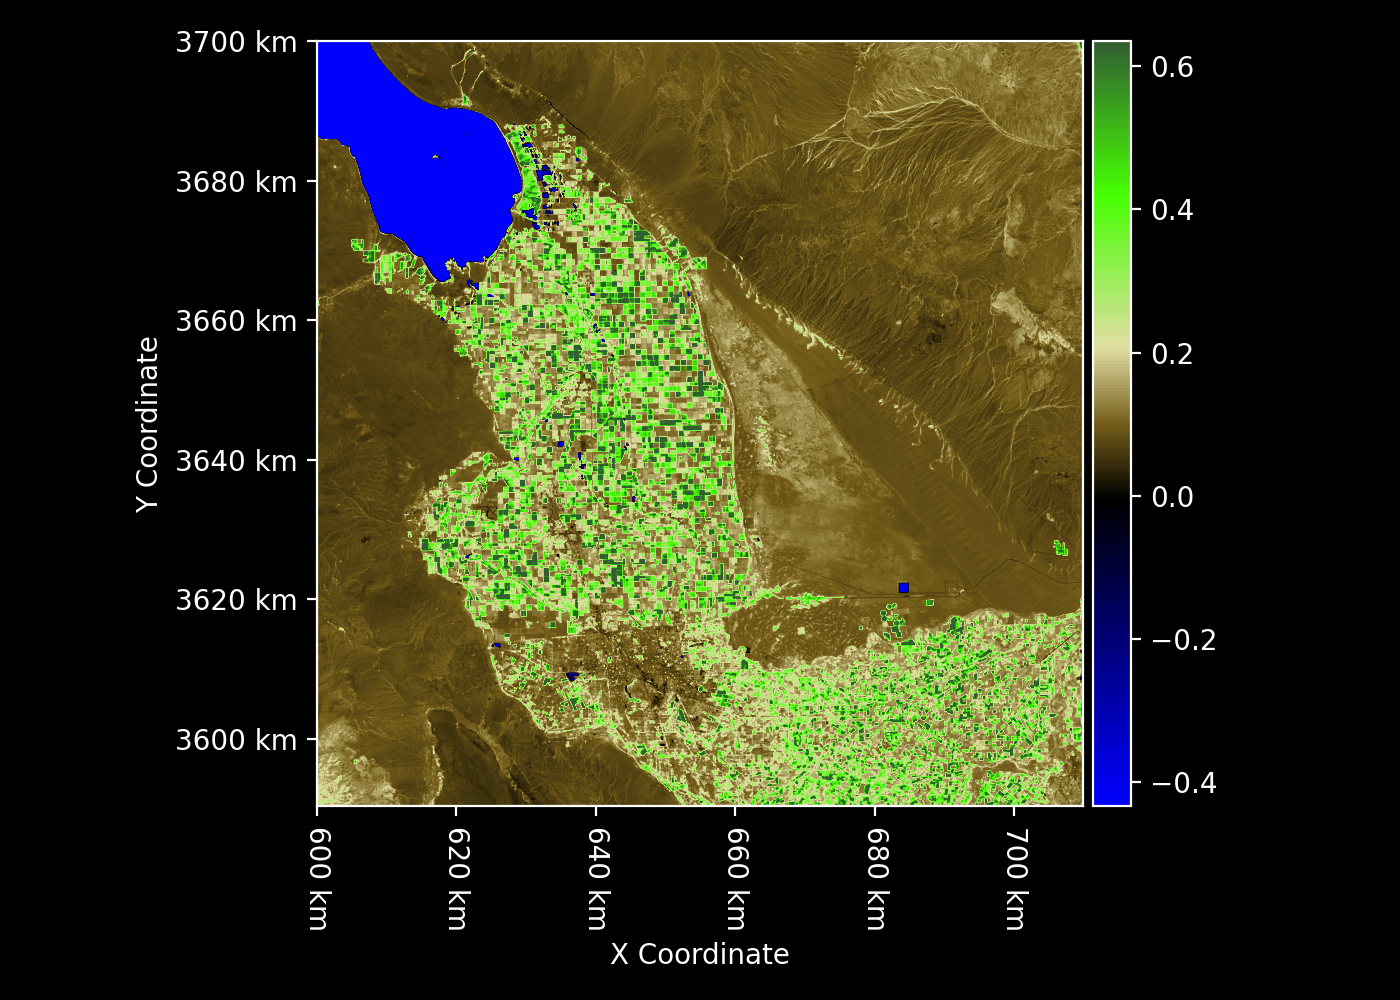

In [10]:
NDVI_tile = L2T_STARS_granule.NDVI
NDVI_tile

In [11]:
tile_geometry = NDVI_tile.geometry
tile_geometry

{
  "dimensions": {
    "rows": 1568,
    "cols": 1568
  },
  "bbox": {
    "xmin": 600000.0,
    "ymin": 3590260.0,
    "xmax": 709760.0,
    "ymax": 3700020.0
  },
  "crs": "EPSG:32611",
  "resolution": {
    "cell_width": 70.0,
    "cell_height": -70.0
  }
}

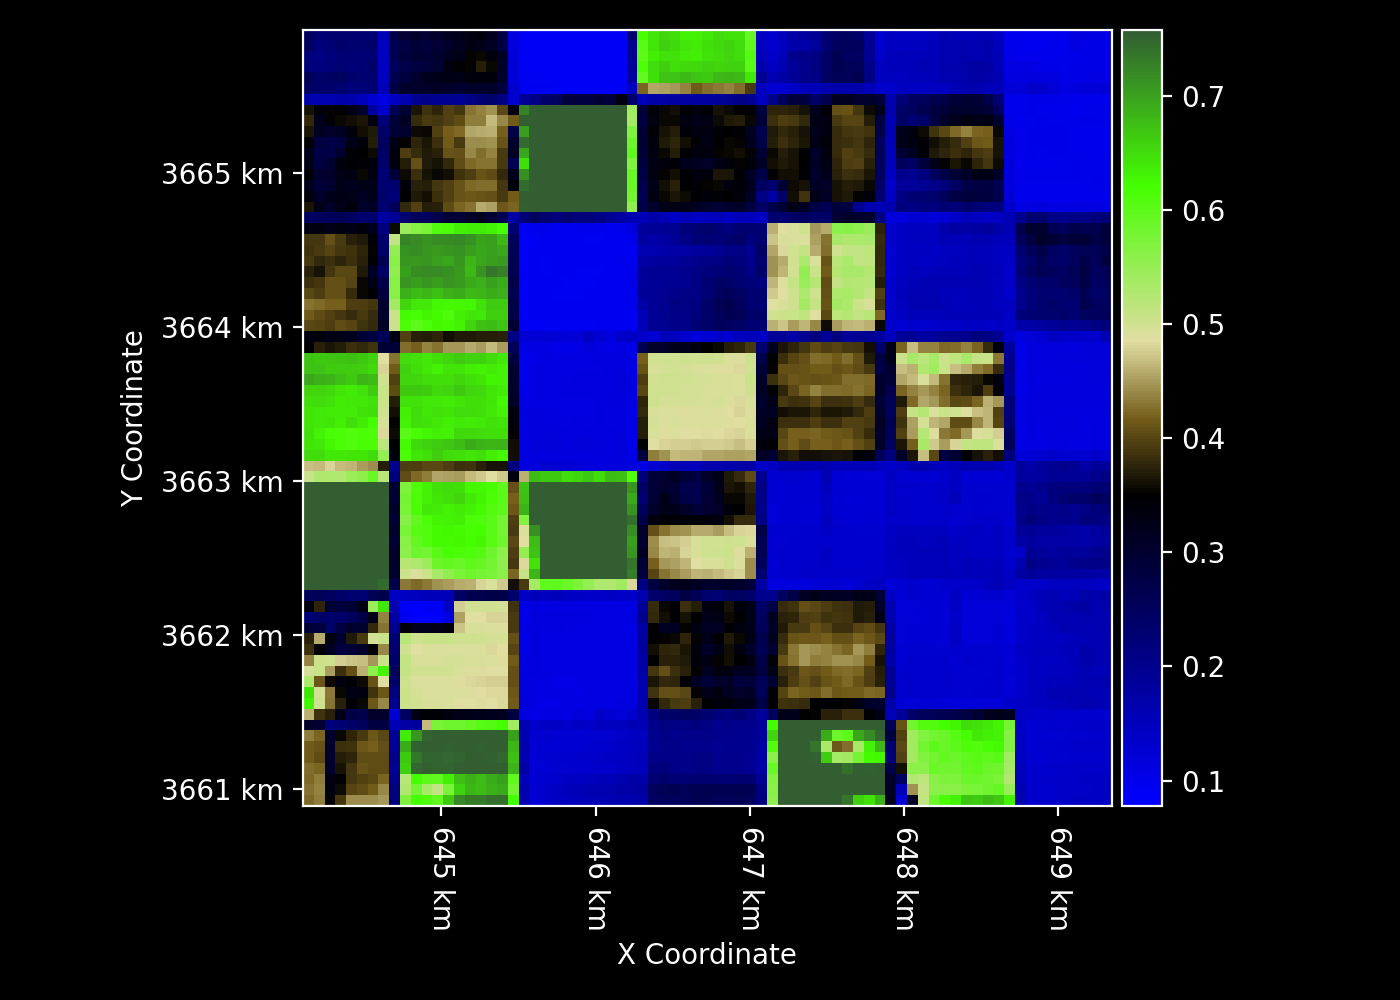

In [12]:
NDVI = NDVI_tile.to_geometry(geometry)
NDVI

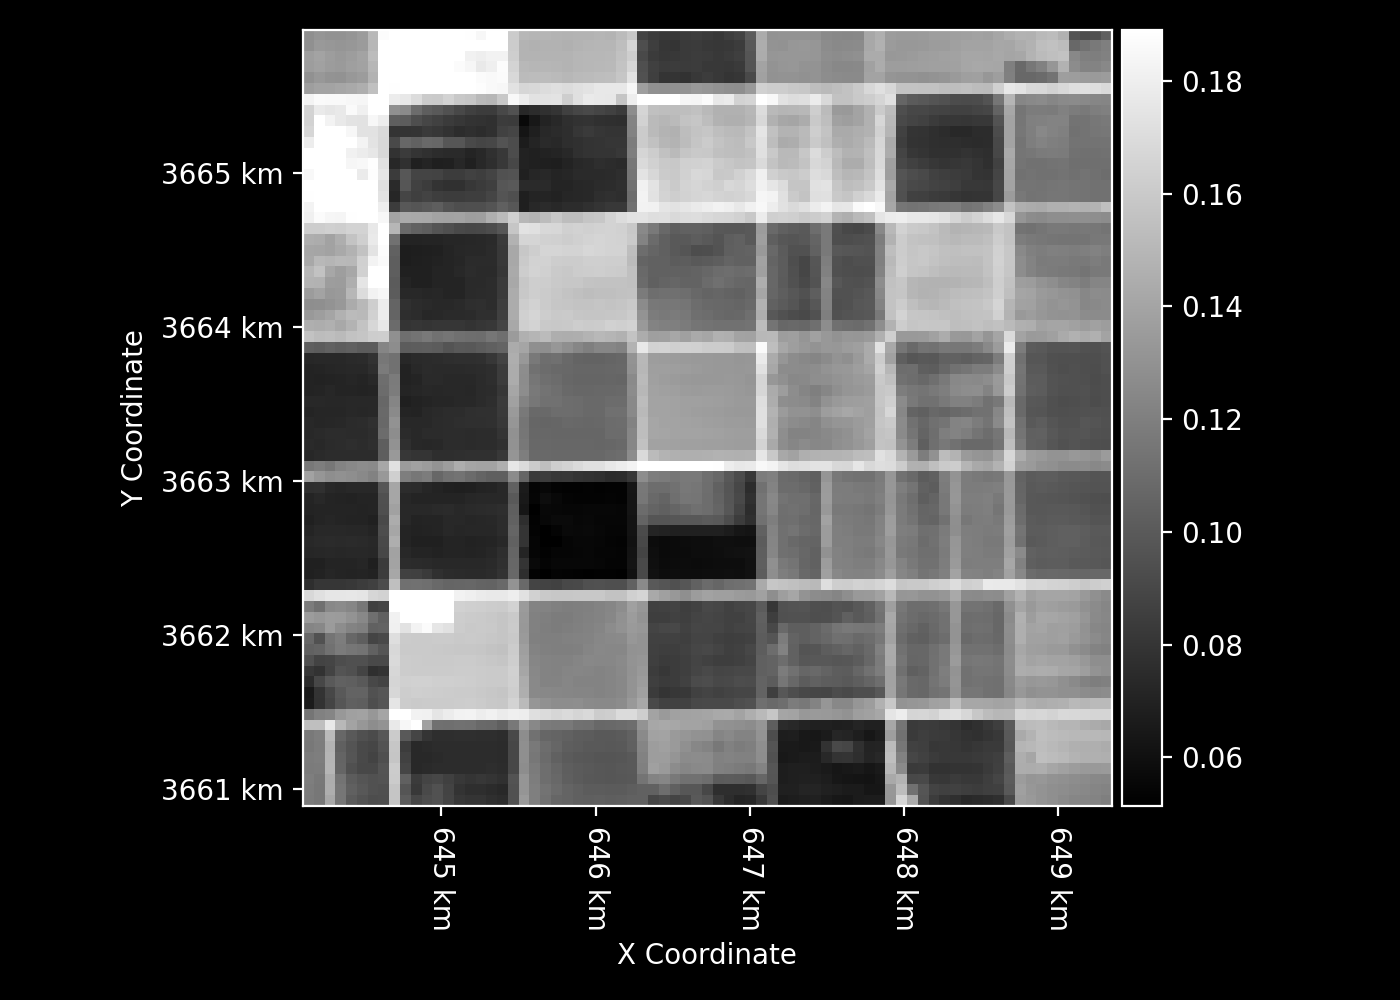

In [13]:
albedo = L2T_STARS_granule.albedo.to_geometry(geometry)
albedo

In [14]:
L3T_SEB_granule = download_ECOSTRESS_granule(
    product="L3T_SEB", 
    orbit=orbit,
    scene=scene,
    tile=tile, 
    aquisition_date=aquisition_date,
    parent_directory=ECOSTRESS_download_directory
)

L3T_SEB_granule

L3TSEB("/Users/gregoryhalverson/data/ECOSTRESS/ECOv002_L3T_SEB_35698_014_11SPS_20241022T183627_0713_01")

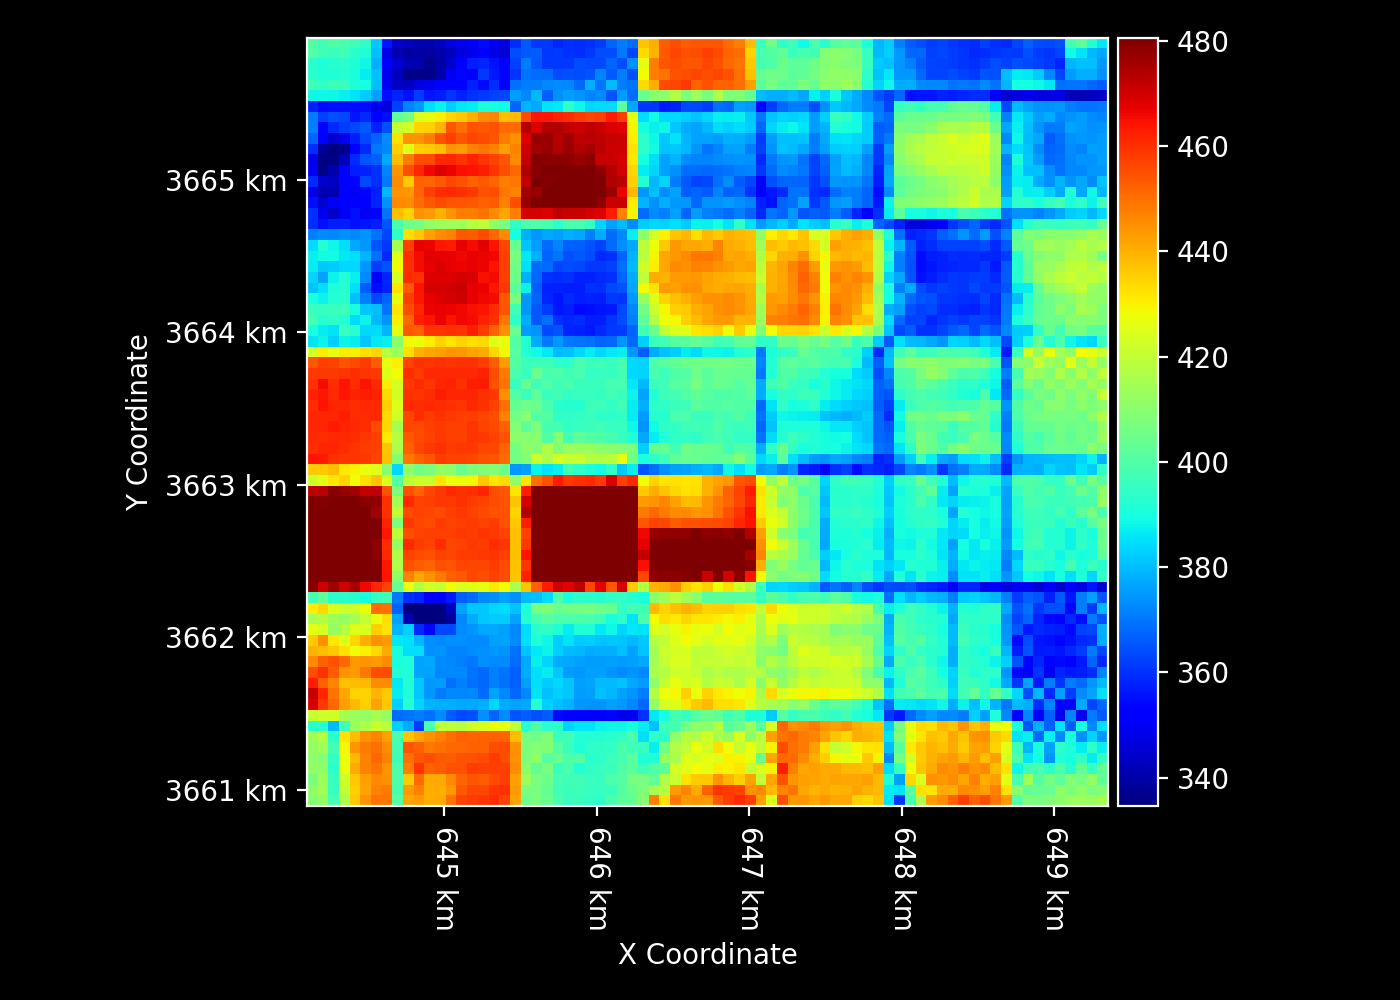

In [15]:
Rn = L3T_SEB_granule.variable("Rn").to_geometry(geometry)
Rn

In [16]:
L3T_MET_granule = download_ECOSTRESS_granule(
    product="L3T_MET", 
    orbit=orbit,
    scene=scene,
    tile=tile, 
    aquisition_date=aquisition_date,
    parent_directory=ECOSTRESS_download_directory
)

L3T_MET_granule

L3TMET("/Users/gregoryhalverson/data/ECOSTRESS/ECOv002_L3T_MET_35698_014_11SPS_20241022T183627_0713_01")

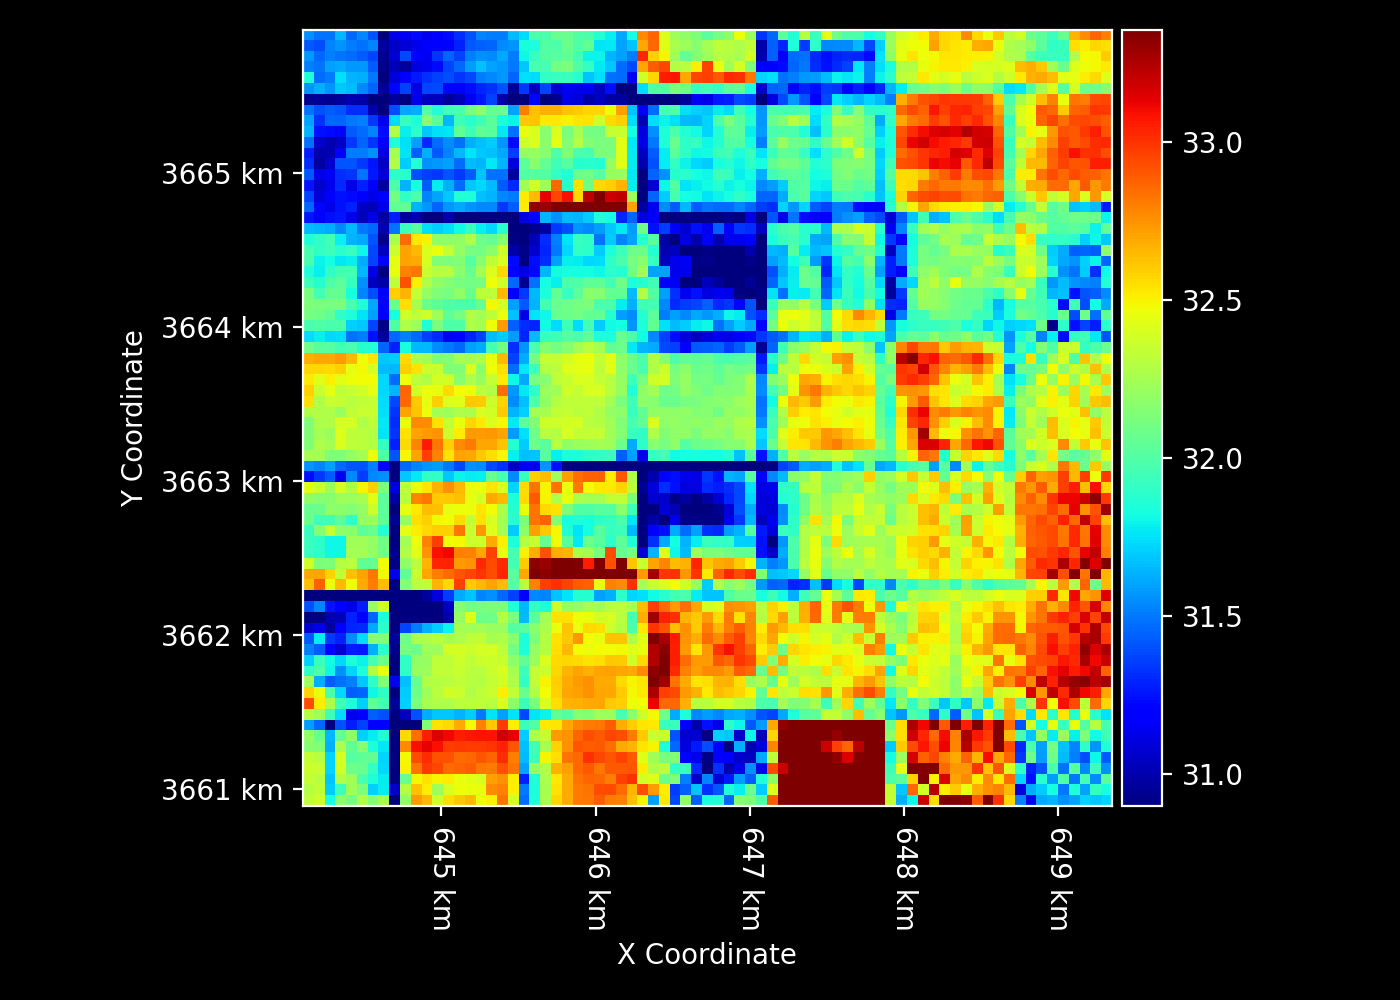

In [17]:
Ta_C = L3T_MET_granule.variable("Ta").to_geometry(geometry)
Ta_C

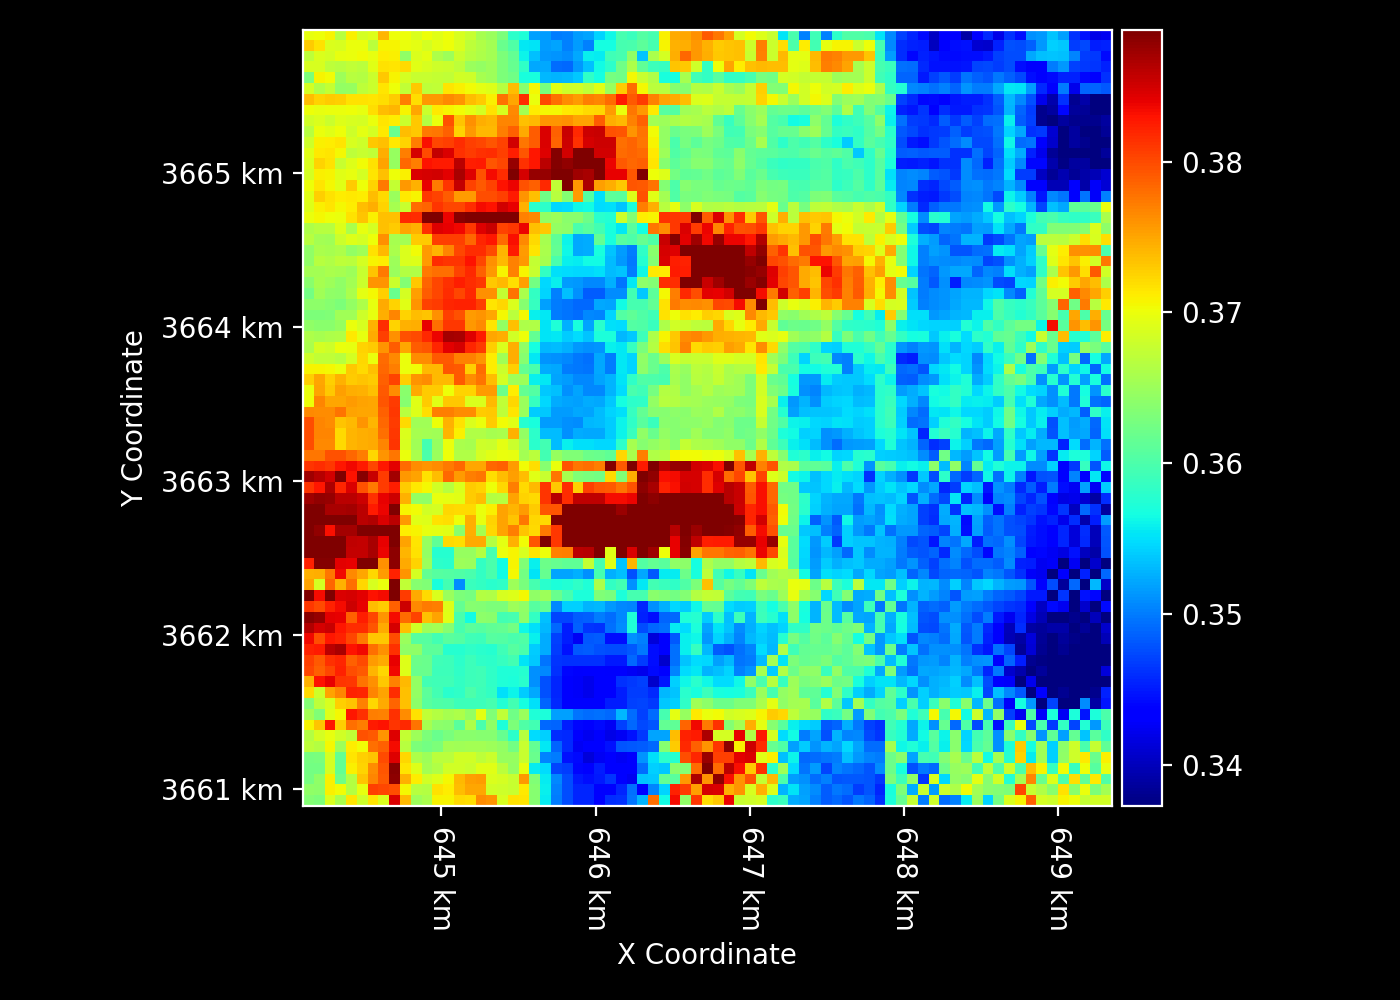

In [18]:
RH = L3T_MET_granule.variable("RH").to_geometry(geometry)
RH

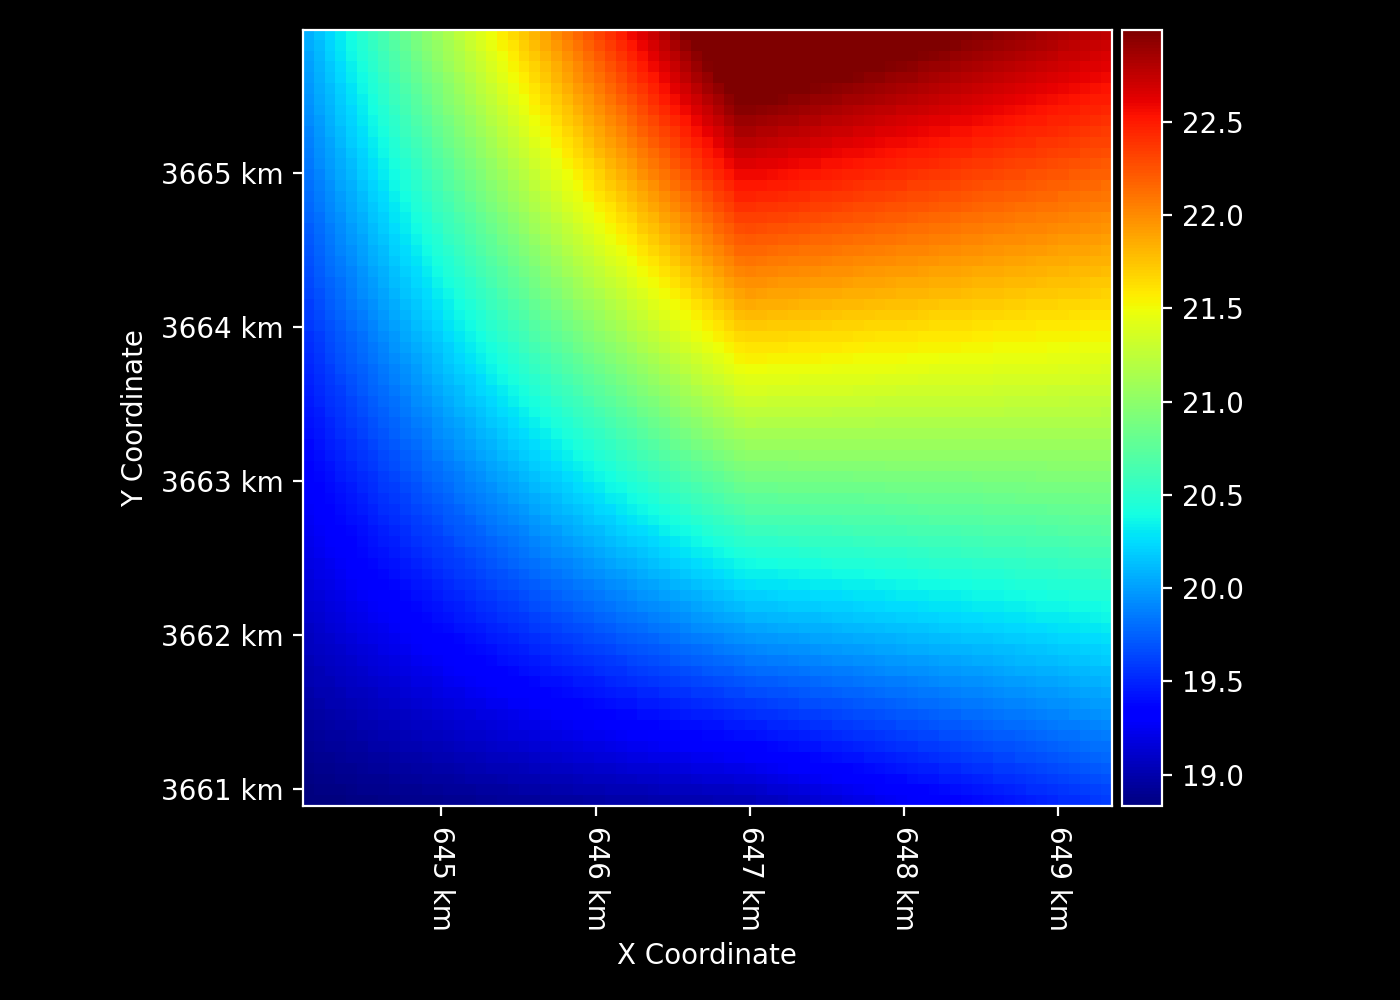

In [19]:
Topt = load_Topt(geometry)
Topt

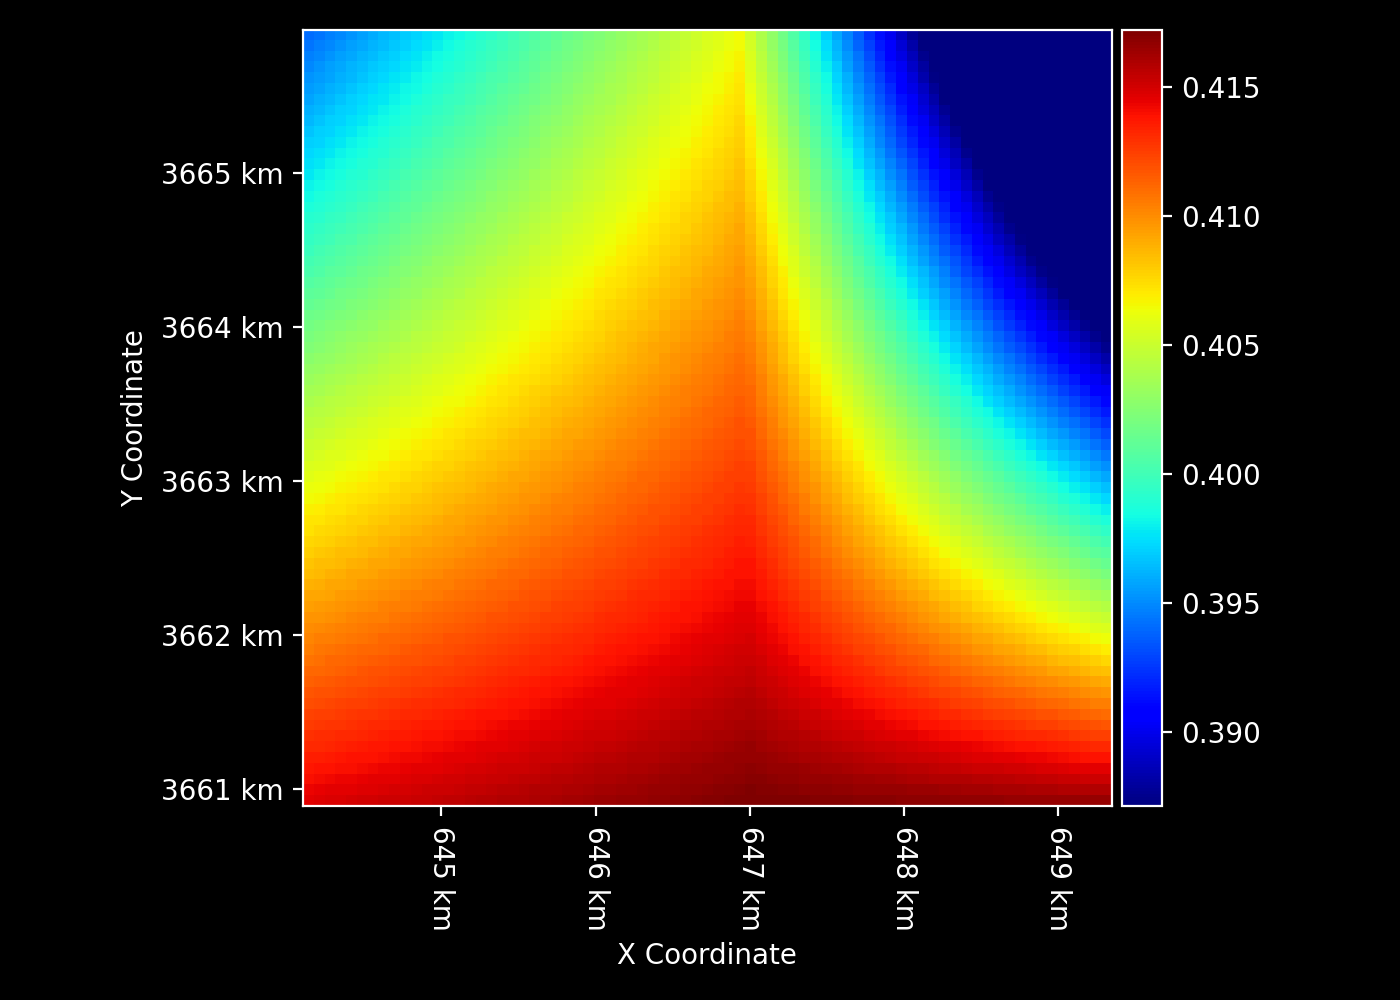

In [20]:
fAPARmax = load_fAPARmax(geometry)
fAPARmax

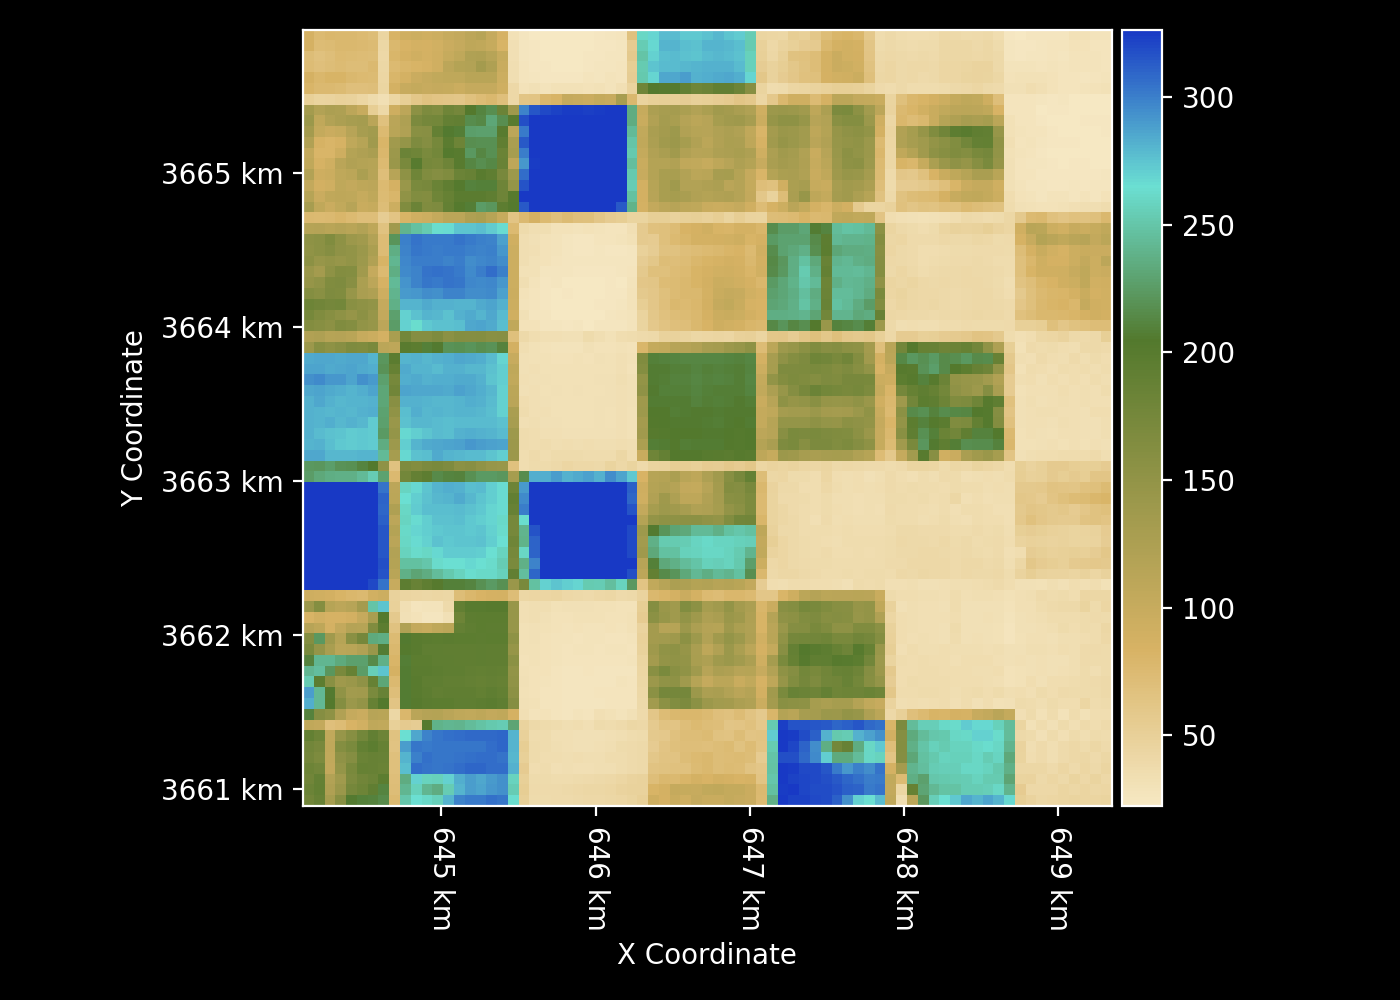

In [21]:
results = PTJPL(
    NDVI=NDVI,
    Ta_C=Ta_C,
    RH=RH,
    Rn=Rn,
    albedo=albedo,
    ST_C=ST_C
)

LE = results["LE"]
LE.cmap = ET_COLORMAP
LE

In [22]:
shifted_tile_geometry = tile_geometry.shift_distance(70, 0)
shifted_tile_geometry

{
  "dimensions": {
    "rows": 1568,
    "cols": 1568
  },
  "bbox": {
    "xmin": 600070.0,
    "ymin": 3590260.0,
    "xmax": 709830.0,
    "ymax": 3700020.0
  },
  "crs": "EPSG:32611",
  "resolution": {
    "cell_width": 70.0,
    "cell_height": -70.0
  }
}

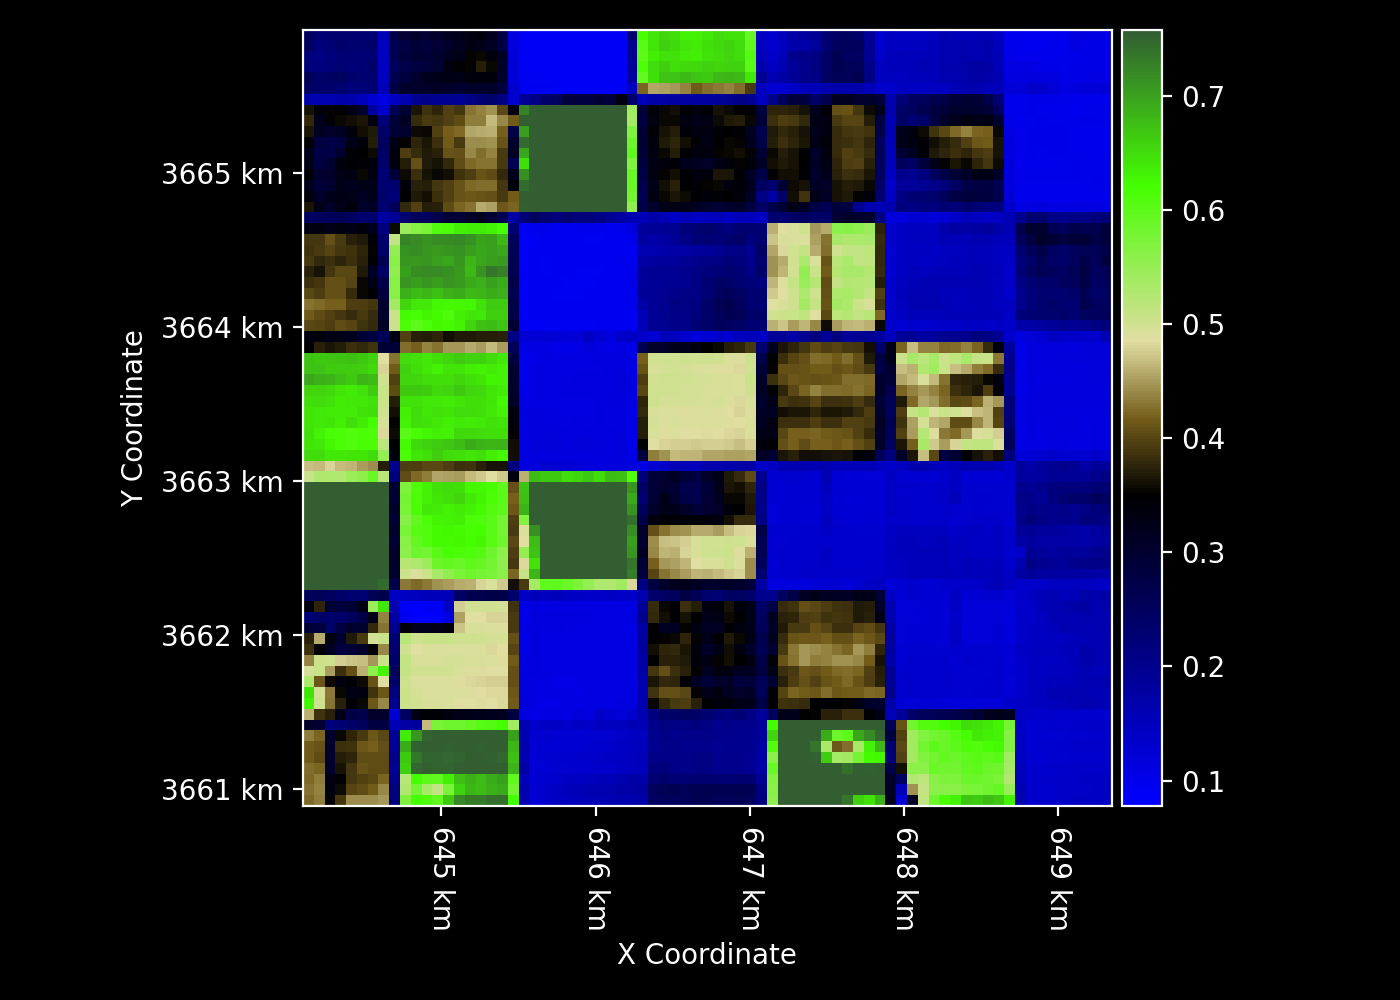

In [23]:
NDVI

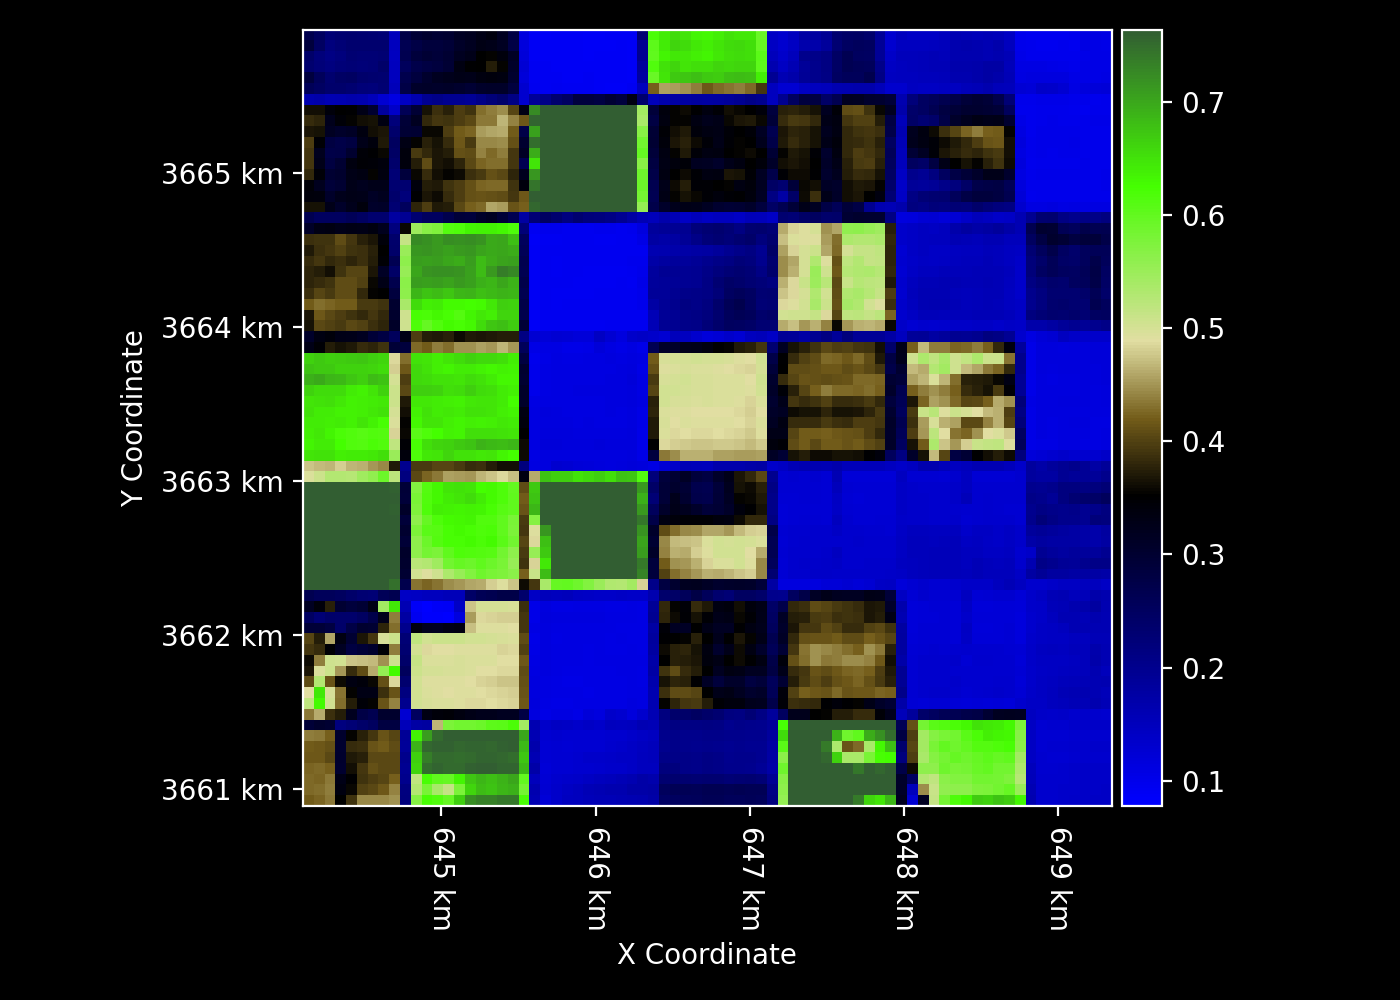

In [24]:
shifted_NDVI_tile = rt.Raster(NDVI_tile, geometry=shifted_tile_geometry)
shifted_NDVI = shifted_NDVI_tile.to_geometry(geometry, resampling="linear")
shifted_NDVI.cmap = NDVI_COLORMAP
shifted_NDVI

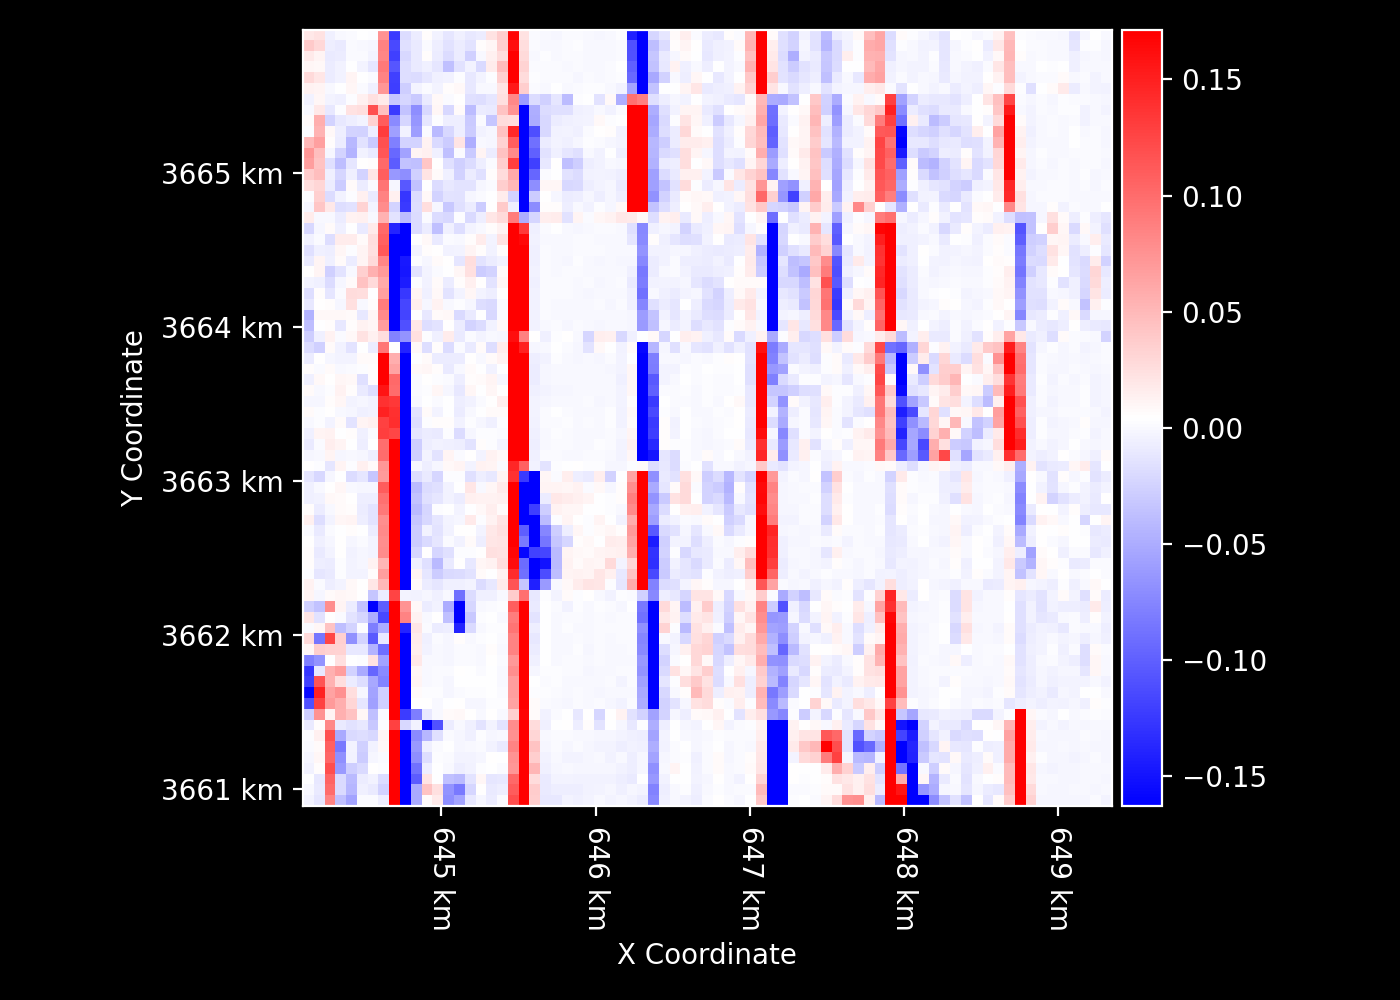

In [25]:
NDVI_error = shifted_NDVI - NDVI
NDVI_error.cmap = error_cmap
NDVI_error

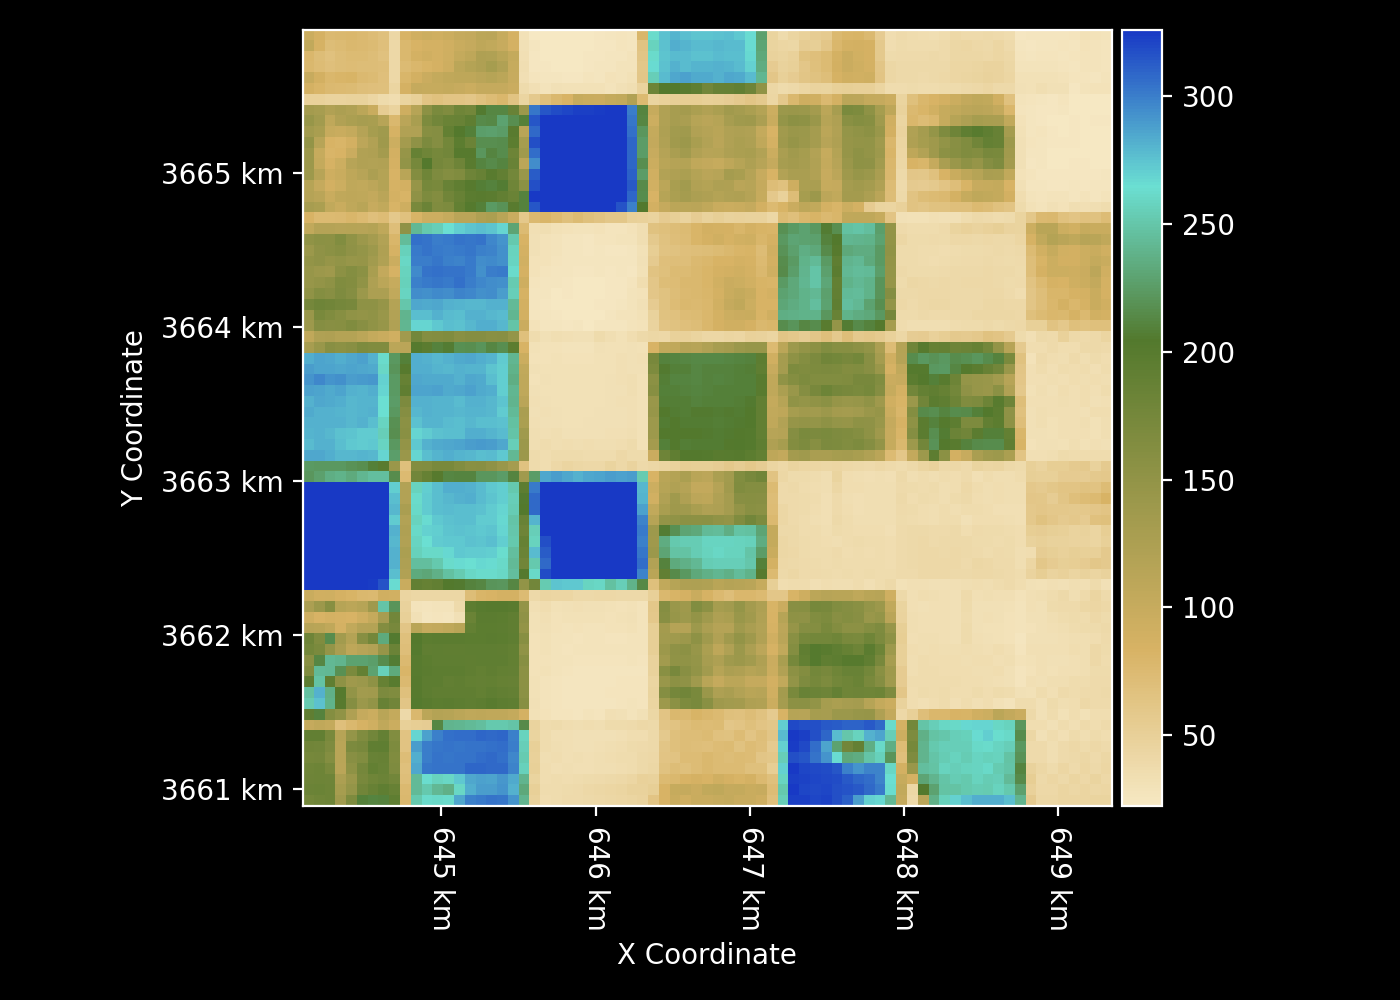

In [26]:
shifted_results = PTJPL(
    NDVI=shifted_NDVI,
    Ta_C=Ta_C,
    RH=RH,
    Rn=Rn,
    albedo=albedo,
    ST_C=ST_C
)

shifted_LE = shifted_results["LE"]
shifted_LE.cmap = ET_COLORMAP
shifted_LE

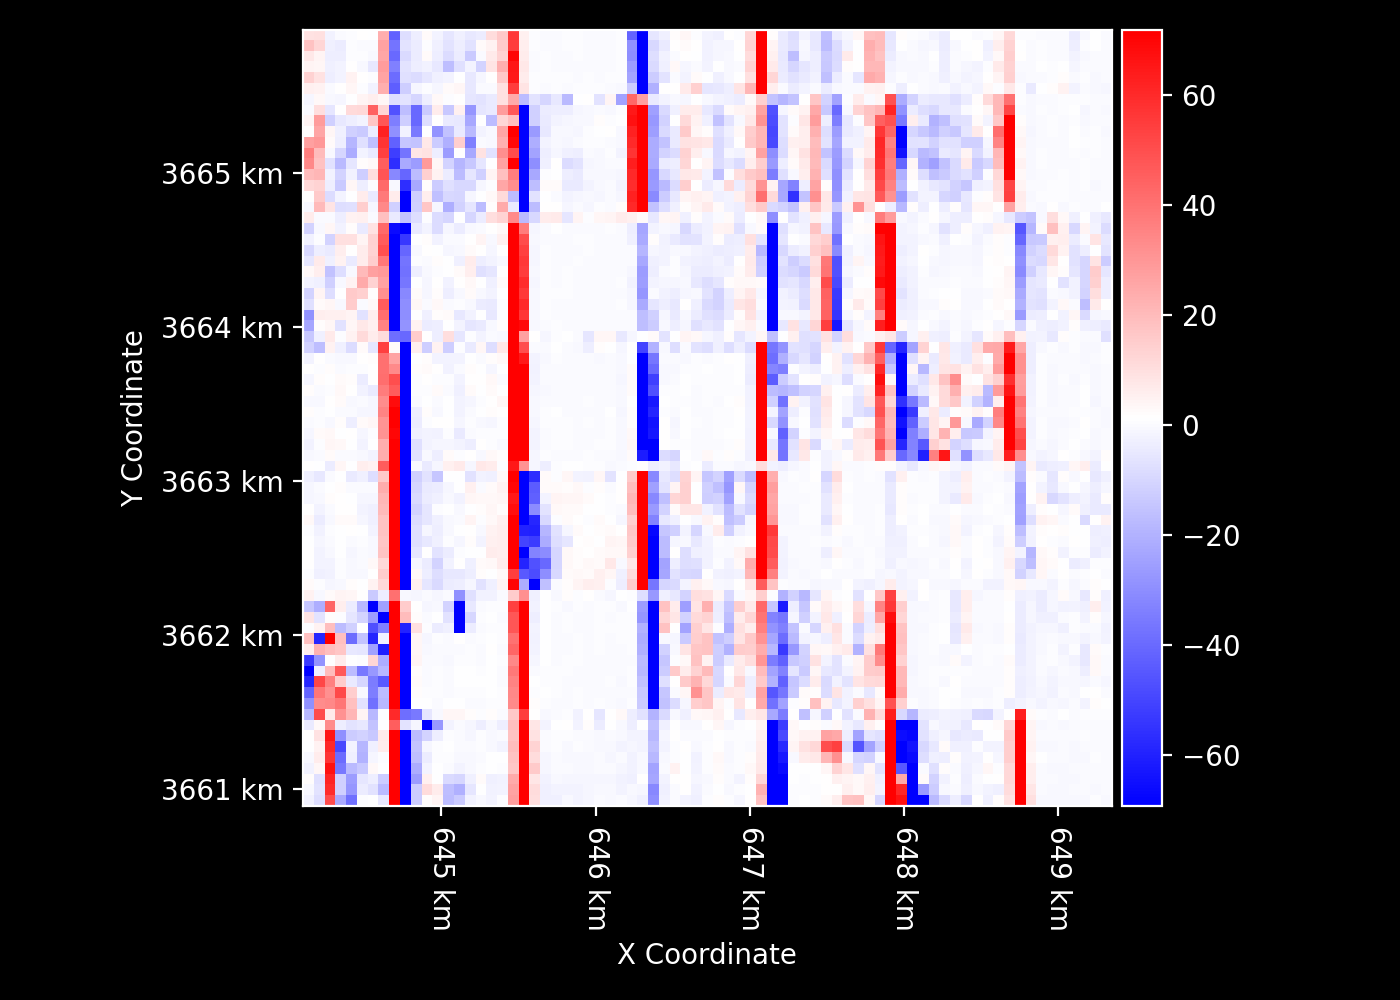

In [27]:
LE_error = shifted_LE - LE
LE_error.cmap = error_cmap
LE_error

In [28]:
n=500

In [29]:
directions = np.random.uniform(0, 360, n)
directions

array([2.47911188e+01, 1.89357636e+02, 9.77836694e+01, 1.93314289e+02,
       9.98637458e+01, 4.31780467e+01, 3.29639296e+02, 1.94024719e+02,
       2.32517476e+02, 1.88191017e+01, 1.43506278e+00, 4.09637412e+01,
       5.22029868e+01, 1.56379211e+02, 2.17042583e+01, 1.93002234e+02,
       1.74574460e+01, 2.62356057e+02, 7.75031862e+01, 1.95208152e+02,
       1.36292704e+02, 2.71335374e+02, 2.42633454e+02, 1.55834200e+02,
       1.48474245e+02, 3.39918866e+02, 1.00078973e+02, 2.25355153e+02,
       9.74253471e+01, 3.35301502e+02, 9.58227526e+01, 2.01014699e+02,
       3.93499120e+01, 5.44041179e+01, 1.39855148e+02, 1.04804842e+02,
       2.48412639e+02, 8.84339974e+01, 2.39903758e+01, 3.00357227e+02,
       2.92422672e+02, 2.57743022e+02, 2.01261833e+01, 3.50094796e+02,
       1.53919782e+02, 5.07582290e+01, 1.96288563e+02, 7.43964003e+01,
       3.58772982e+02, 2.96508567e+02, 1.32272271e+02, 1.41775730e+02,
       2.51545547e+02, 6.45419848e+00, 9.24480716e+01, 3.21307000e+02,
      

In [30]:
min_distance = 0
max_distance = 5 * 70
min_distance, max_distance

(0, 350)

In [31]:
distances = np.random.uniform(min_distance, max_distance, n)
distances

array([264.21693701,  11.84765899, 165.06467103, 197.89397156,
       223.09507514, 312.05259582, 137.1346049 , 200.88634127,
       262.05152779,  25.06799909,  39.0773403 , 255.84407462,
       335.53927224, 281.34066046, 173.80452808, 327.4749368 ,
       121.31163191,  98.23815542,  30.08902834, 163.12804938,
       158.30577783, 340.3256347 , 266.62931704, 101.27260189,
       304.04779613,   7.11465574, 124.84672538,  32.07838666,
        24.61912719, 150.10110907, 265.14011622, 276.46660309,
       201.46512891, 337.0856975 , 293.88074582,  37.35586384,
       211.18656487,  59.03419965, 333.89332278, 155.94439329,
       349.72724999,   7.84717581,  85.96204948, 287.09541478,
       118.44289189, 261.69941922, 159.75790306,   7.10275033,
       204.89634725, 238.27476724, 146.78091823, 185.84856962,
         1.64649412, 111.92579508, 264.0081702 , 190.33977316,
       133.78300457, 256.79588758, 221.04983849, 343.67206496,
       275.6369168 , 148.86953258, 170.51461138,  31.40

In [37]:
df = pd.DataFrame({
    "distance": [],
    "direction": [],
    "NDVI_error": [],
    "LE_error": [],
    "NDVI": [],
    "LE": []
})

for distance, direction in zip(distances, directions):
    shifted_tile_geometry = tile_geometry.shift_distance(distance, direction)
    shifted_NDVI_tile = rt.Raster(NDVI_tile, geometry=shifted_tile_geometry)
    shifted_NDVI = shifted_NDVI_tile.to_geometry(geometry, resampling="linear")

    NDVI_error = shifted_NDVI - NDVI
    
    shifted_results = PTJPL(
        NDVI=shifted_NDVI,
        Ta_C=Ta_C,
        RH=RH,
        Rn=Rn,
        albedo=albedo,
        ST_C=ST_C
    )

    shifted_LE = shifted_results["LE"]
    LE_error = shifted_LE - LE

    # df = pd.concat([df, pd.DataFrame({
    #     "distance": distance,
    #     "direction": direction,
    #     "NDVI_error": NDVI_error.flatten(),
    #     "LE_error": LE_error.flatten(),
    #     "NDVI": NDVI.flatten(),
    #     "LE": LE.flatten()
    # })])

    df = pd.concat([df, pd.DataFrame({
        "distance": [distance],
        "direction": [direction],
        "NDVI_error": [np.nanmean(np.abs(NDVI_error))],
        "LE_error": [np.nanmean(np.abs(LE_error))],
        "NDVI": [np.nanmean(NDVI)],
        "LE": [np.nanmean(LE)]
    })])

df

/var/folders/bv/410kt7f93x78j9dww00h1pz80000gn/T/ipykernel_49575/4104929320.py:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  "NDVI_error": [np.nanmean(np.abs(NDVI_error))],
/var/folders/bv/410kt7f93x78j9dww00h1pz80000gn/T/ipykernel_49575/4104929320.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  "LE_error": [np.nanmean(np.abs(LE_error))],
/var/folders/bv/410kt7f93x78j9dww00h1pz80000gn/T/ipykernel_49575/4104929320.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({
/var/folders/bv/410kt7f93x78j9dww00h1pz80000gn/T/ipy

,distance,direction,NDVI_error,LE_error,NDVI,LE
0,264.216937,24.791119,0.112112,45.860867,0.335572,130.636351
0,11.847659,189.357636,0.006474,2.556974,0.335572,130.636351
0,165.064671,97.783669,0.071081,28.955844,0.335572,130.636351
0,197.893972,193.314289,0.086495,35.917192,0.335572,130.636351
0,223.095075,99.863746,0.089844,36.945161,0.335572,130.636351
...,...,...,...,...,...,...
0,279.257797,261.722133,0.108319,44.575863,0.335572,130.636351
0,279.207298,207.409751,0.119028,48.910114,0.335572,130.636351
0,153.262561,65.915044,0.080410,33.194586,0.335572,130.636351
0,242.538058,231.026117,0.109681,45.289807,0.335572,130.636351


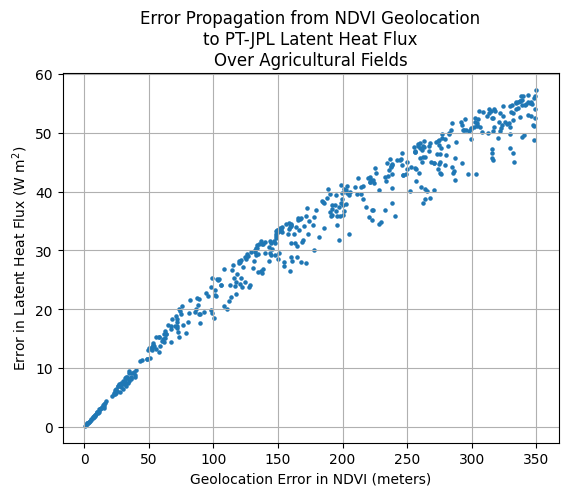

In [38]:
plt.scatter(x=df.distance, y=df.LE_error, s=5)
plt.xlabel('Geolocation Error in NDVI (meters)')
plt.ylabel('Error in Latent Heat Flux (W m$^2$)')
plt.title("Error Propagation from NDVI Geolocation\nto PT-JPL Latent Heat Flux\nOver Agricultural Fields")
plt.grid(True)

plt.savefig("Error Propagation from NDVI Geolocation to PT-JPL Latent Heat Flux Over Agricultural Fields.png", bbox_inches="tight")

plt.show()

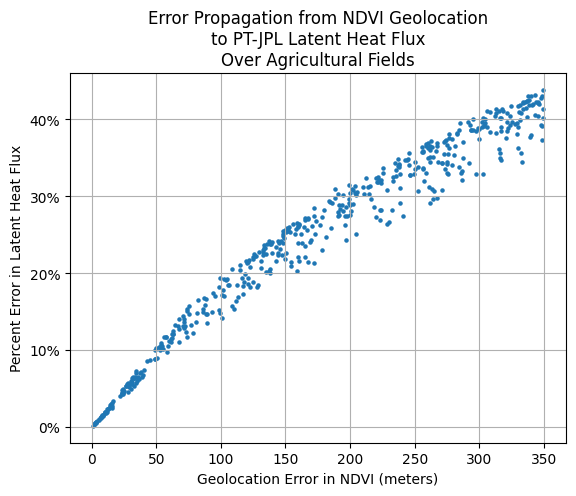

In [42]:
plt.scatter(x=df.distance, y=(df.LE_error / df.LE * 100), s=5)
plt.xlabel('Geolocation Error in NDVI (meters)')
plt.ylabel('Percent Error in Latent Heat Flux')
plt.title("Error Propagation from NDVI Geolocation\nto PT-JPL Latent Heat Flux\nOver Agricultural Fields")
plt.grid(True)

# Function to format y-axis labels with percent sign
def percent_formatter(x, pos):
    return f'{x:.0f}%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.savefig("Error Propagation from NDVI Geolocation to PT-JPL Latent Heat Flux Over Agricultural Fields.png", bbox_inches="tight")

plt.show()

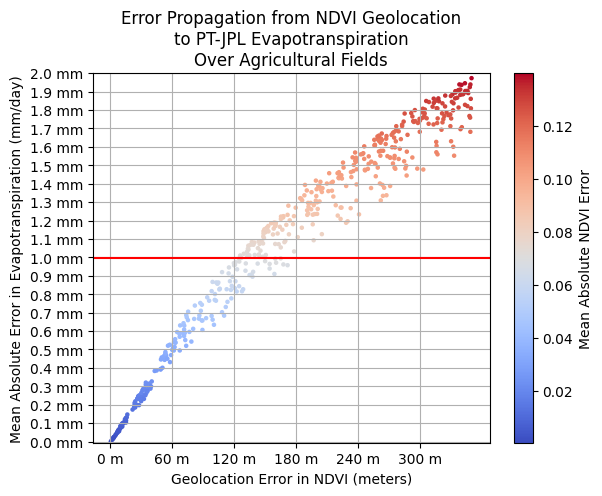

In [58]:
scatter = plt.scatter(x=df.distance, y=df.LE_error / 28.94, c=df.NDVI_error, s=5, cmap='coolwarm')
plt.xlabel('Geolocation Error in NDVI (meters)')
plt.ylabel('Mean Absolute Error in Evapotranspiration (mm/day)')
plt.title("Error Propagation from NDVI Geolocation\nto PT-JPL Evapotranspiration\nOver Agricultural Fields")
plt.grid(True)

# Set y-axis ticks interval to 0.1 and label them with "mm"
y_ticks = np.arange(min(df.LE_error / 28.94), max(df.LE_error / 28.94) + 0.1, 0.1)
plt.ylim(0, 2)
plt.yticks(y_ticks, [f'{tick:.1f} mm' for tick in y_ticks])

# Set x-axis ticks interval to 60 and format them as integers
x_ticks = np.arange(0, 360, 60)
plt.xticks(x_ticks, [f'{int(tick)} m' for tick in x_ticks])

# Add horizontal red lines at y=1 and y=-1
plt.axhline(y=1, color='red', linestyle='-')
plt.axhline(y=-1, color='red', linestyle='-')

# Show color bar legend
plt.colorbar(scatter, label='Mean Absolute NDVI Error')

plt.savefig("Error Propagation from NDVI Geolocation to PT-JPL Evapotranspiration Over Agricultural Fields.png", bbox_inches="tight")

plt.show()

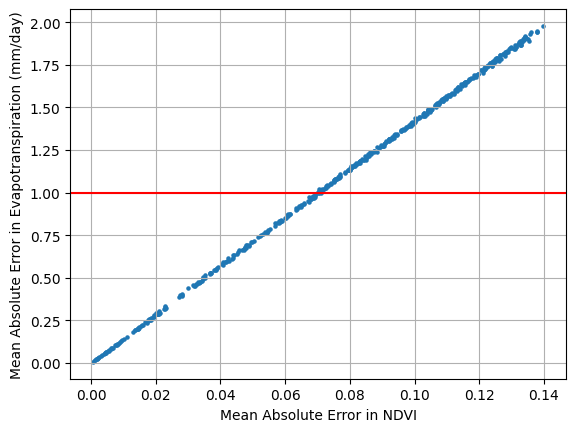

In [66]:
scatter = plt.scatter(x=df.NDVI_error, y=df.LE_error / 28.94, s=5)
plt.xlabel('Mean Absolute Error in NDVI')
plt.ylabel('Mean Absolute Error in Evapotranspiration (mm/day)')
plt.grid(True)

# Add a horizontal red line at y=1
plt.axhline(y=1, color='red', linestyle='-')

plt.show()

In [62]:
np.nanmean((df.LE_error / 28.94) / df.NDVI_error)

np.float64(14.156955085771052)